In [3]:
import wandb
from wandb.keras import WandbCallback

%wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [5]:
import tensorflow as tf
from tensorflow.keras.layers import MaxPooling2D, Input, concatenate, Conv2D, Activation, ZeroPadding2D, UpSampling2D, add
from tensorflow.keras.models import *
from qkeras import *

import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import load_img

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import shuffle
from tqdm import tqdm

In [7]:
#TODO: Data generation
PRETRAINED = True
BASE_PATH = "drive/MyDrive/MS Research/High Energy Physics/data/images/"
IMG_PATH = 'input/'
ANNOTATION_PATH = 'trimaps/'
num = 4000

input_img_paths = sorted(
    [
        os.path.join(BASE_PATH, IMG_PATH, fname)
        for fname in os.listdir(BASE_PATH+IMG_PATH)
        if fname.endswith(".png") and "(" not in fname
    ]
)[:num]


annotation_img_paths = []

for fname in tqdm(input_img_paths[:num]):
  annp = os.path.join(BASE_PATH, ANNOTATION_PATH, fname.split("/")[-1].replace("img", "annm"))
  if os.path.isfile(annp):
    annotation_img_paths.append(annp)
    input_img_paths.append(fname)
  else:
    pass

input_img_paths = input_img_paths[num:]
len(input_img_paths), len(annotation_img_paths)

100%|██████████| 4000/4000 [00:20<00:00, 199.80it/s] 


(3915, 3915)

In [8]:
[x for x in input_img_paths if "(" in x]

[]

In [9]:
input_img_paths[0], annotation_img_paths[0]

('drive/MyDrive/MS Research/High Energy Physics/data/images/input/ECAL_img_0.png',
 'drive/MyDrive/MS Research/High Energy Physics/data/images/trimaps/ECAL_annm_0.png')

[1607 1809 1791  134]


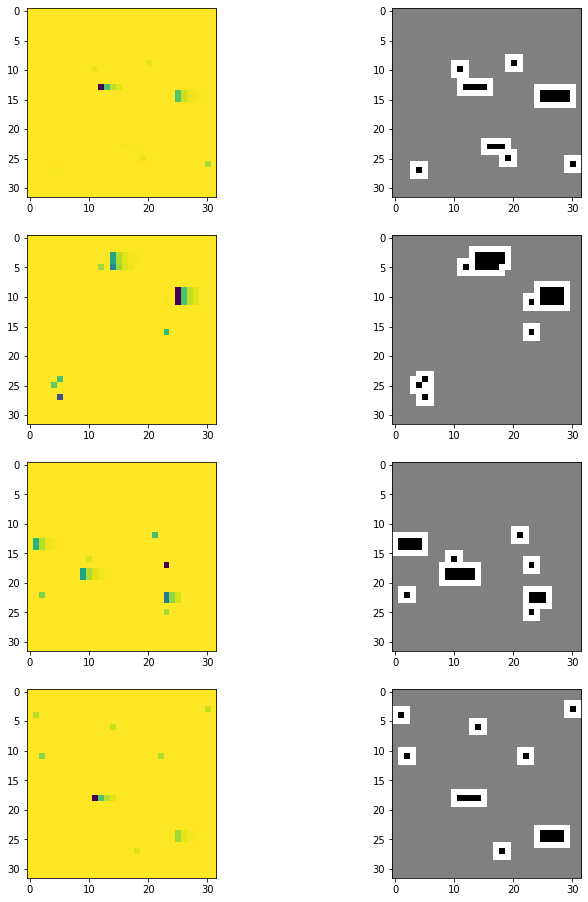

In [10]:
num_example_to_display = 4

sample_idxs = np.random.randint(0, len(input_img_paths)-1, size=(num_example_to_display,))
#sample_idxs = [0, 1, 2, 3]
print(sample_idxs)

fig, axs = plt.subplots(nrows=num_example_to_display, ncols=2, figsize=(12,4*num_example_to_display))

for i, sample_idx in enumerate(sample_idxs):
  img = Image.open(input_img_paths[sample_idx]) 
  mask = Image.open(annotation_img_paths[sample_idx])
  #img = Image.fromarray(np.array(img))
  axs[i][0].imshow(img)
  axs[i][1].imshow(mask, cmap='gray')

In [11]:
np.unique(mask)

array([1, 2, 3], dtype=uint8)

In [12]:
IMG_SHAPE = 32

def normalize(image, mask):
  image = tf.cast(image, tf.float32) / 255.0
  mask -= 1
  return image, mask

def load_and_preprocess(img_filepath, mask_filepath):
    img = tf.io.read_file(img_filepath)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SHAPE, IMG_SHAPE])


    mask = tf.io.read_file(mask_filepath)
    mask = tf.io.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [IMG_SHAPE, IMG_SHAPE])

    img, mask = normalize(img, mask)

    return img, mask

In [13]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32

input_img_paths, annotation_img_paths = shuffle(input_img_paths, annotation_img_paths, random_state=42)
input_img_paths_train, annotation_img_paths_train = input_img_paths[: -1200], annotation_img_paths[: -1200]
input_img_paths_test, annotation_img_paths_test = input_img_paths[-1200:-800], annotation_img_paths[-1200:-800]

trainloader = tf.data.Dataset.from_tensor_slices((input_img_paths_train, annotation_img_paths_train))
testloader = tf.data.Dataset.from_tensor_slices((input_img_paths_test, annotation_img_paths_test))

trainloader = (
    trainloader
    .shuffle(1024)
    .map(load_and_preprocess, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

testloader = (
    testloader
    .map(load_and_preprocess, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [14]:
input_img_paths_test, annotation_img_paths_test = input_img_paths[-800:], annotation_img_paths[-800:]
maintestloader = tf.data.Dataset.from_tensor_slices((input_img_paths_test, annotation_img_paths_test))

maintestloader = (
    maintestloader
    .map(load_and_preprocess, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

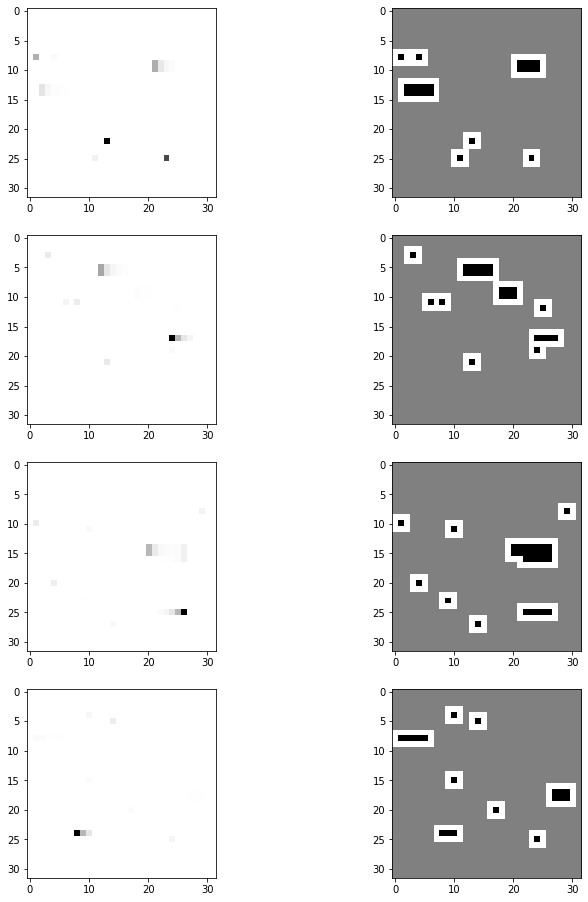

In [15]:
num_example_to_display = 4

img, mask = next(iter(trainloader))

fig, axs = plt.subplots(nrows=num_example_to_display, ncols=2, figsize=(12,4*num_example_to_display))

for i in range(num_example_to_display):
  axs[i][0].imshow(img[i]);
  axs[i][1].imshow(np.squeeze(mask[i],-1), cmap='gray');

In [16]:
np.unique(mask)

array([0., 1., 2.], dtype=float32)

In [17]:
# ref: https://github.com/ayulockin/deepimageinpainting/blob/master/Image_Inpainting_Autoencoder_Decoder_v2_0.ipynb
class SegmentationModel:
  '''
  Build UNET based model for segmentation task.
  '''
  def prepare_model(self, OUTPUT_CHANNEL, input_size=(IMG_SHAPE,IMG_SHAPE,3)):
    inputs = Input(input_size)

    conv1, pool1 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', inputs) 
    conv2, pool2 = self.__ConvBlock(64, (3,3), (2,2), 'relu', 'same', pool1)
    conv3, pool3 = self.__ConvBlock(128, (3,3), (2,2), 'relu', 'same', pool2) 
    conv4, pool4 = self.__ConvBlock(256, (3,3), (2,2), 'relu', 'same', pool3) 
    
    conv5, up6 = self.__UpConvBlock(512, 256, (3,3), (2,2), (2,2), 'relu', 'same', pool4, conv4)
    conv6, up7 = self.__UpConvBlock(256, 128, (3,3), (2,2), (2,2), 'relu', 'same', up6, conv3)
    conv7, up8 = self.__UpConvBlock(128, 64, (3,3), (2,2), (2,2), 'relu', 'same', up7, conv2)
    conv8, up9 = self.__UpConvBlock(64, 32, (3,3), (2,2), (2,2), 'relu', 'same', up8, conv1)
    
    conv9 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', up9, False)
    
    outputs = Conv2D(OUTPUT_CHANNEL, (3, 3), activation='softmax', padding='same')(conv9)

    return Model(inputs=[inputs], outputs=[outputs])  

  def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
    conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    if pool_layer:
      pool = MaxPooling2D(pool_size)(conv)
      return conv, pool
    else:
      return conv

  def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
    conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    up = Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
    up = concatenate([up, shared_layer], axis=3)

    return conv, up

In [18]:
class UNETLiteModel:
  '''
  Build UNET based model for segmentation task.
  '''
  def prepare_model(self, OUTPUT_CHANNEL, input_size=(IMG_SHAPE,IMG_SHAPE,3)):
    inputs = Input(input_size)

    conv1, pool1 = self.__ConvBlock(8, (3,3), (2,2), 'relu', 'same', inputs) 
    conv2, pool2 = self.__ConvBlock(16, (3,3), (2,2), 'relu', 'same', pool1)
    conv3, pool3 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', pool2) 

    conv5, up6 = self.__UpConvBlock(64, 32, (3,3), (2,2), (2,2), 'relu', 'same', pool3, conv3)
    conv6, up7 = self.__UpConvBlock(32, 16, (3,3), (2,2), (2,2), 'relu', 'same', up6, conv2)
    conv7, up8 = self.__UpConvBlock(16, 8, (3,3), (2,2), (2,2), 'relu', 'same', up7, conv1)
    
    conv8 = self.__ConvBlock(8, (3,3), (2,2), 'relu', 'same', up8, False)
    
    outputs = Conv2D(OUTPUT_CHANNEL, (3, 3), activation='softmax', padding='same')(conv8)

    return Model(inputs=[inputs], outputs=[outputs])  

  def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
    conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    if pool_layer:
      pool = MaxPooling2D(pool_size)(conv)
      return conv, pool
    else:
      return conv

  def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
    conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    up = Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
    up = concatenate([up, shared_layer], axis=3)

    return conv, up

In [19]:
IMG_SHAPE = 32

class EnetModel:
  '''
  Build ENET based model for segmentation task.
  Built for FPGA 240x152 implementation
  '''
  
  def prepare_model(self, OUTPUT_CHANNEL, input_size=(IMG_SHAPE,IMG_SHAPE,3)):
    # 8x Resolution Model
    fi, f1, f2, f3, f4, f5 = 32, 64, 64, 64, 128, 48

    # 240 x 152
    inputs = Input(input_size)

    initial = self.__InitialBlock(29, (3, 3), (2,2), inputs)
    encode1 = self.__EncoderBlock(fi, f1, initial)
    encode2 = self.__EncoderBlock(f1, f2, encode1)

    # 30 x 19 
    encode3 = Conv2D(filters=f3, kernel_size=(1, 1))(encode2)
    encode3 = BatchNormalization()(encode3)

    decode2 = self.__DecoderBlock(f3, f4, encode3)
    decode1 = self.__DecoderBlock(f4, f5, decode2)
    
    # 240 x 152
    outputs = self.__FinalBlock(OUTPUT_CHANNEL, decode1)

    return Model(inputs=[inputs], outputs=[outputs])  

  def __InitialBlock(self, filters, kernel_size, pool_size, connecting_layer):
    pool_stride = (2, 2)
    pool = MaxPooling2D(pool_size, strides=pool_stride)(connecting_layer)

    # NOTE: unlike paper we do symmetrical padding (1 around)
    padded_pool = ZeroPadding2D(padding=((0, 2), (0, 2)))(pool)
    conv_i = Conv2D(filters=filters, kernel_size=kernel_size)(padded_pool)
    conv_i = BatchNormalization()(conv_i)

    # 3 layers + 29 layers from filters
    concat = concatenate([pool, conv_i], axis=-1)
    out = Activation("relu")(concat)

    return out
  
  def __FinalBlock(self, channels, connecting_layer):
    up_f = UpSampling2D(size=(2, 2))(connecting_layer)
    pad_f = ZeroPadding2D(padding=((0, 1), (0, 1)))(up_f)

    out = Conv2D(filters = channels, kernel_size=(2, 2), activation="softmax")(pad_f)
    return out

  def __EncoderBlock(self, filters_i, filters_o, connecting_layer):
    pool_size, pool_stride = (2, 2), (2, 2)
    pool_1 = MaxPooling2D(pool_size, strides=pool_stride)(connecting_layer)

    # main branch
    padded_pool_1 = ZeroPadding2D(padding=((0, 1), (0, 1)))(pool_1)
    conv_1 = Conv2D(filters=filters_i, kernel_size=(2,2))(padded_pool_1)
    conv_1 = BatchNormalization()(conv_1)

    x_1 = Activation("relu")(conv_1)

    padded_pool_2 = ZeroPadding2D(padding=((0, 2), (0, 2)))(x_1)
    conv_2 = QConv2DBatchnorm(filters=filters_i, kernel_size=(3,3))(padded_pool_2)
    conv_2 = BatchNormalization()(conv_2)

    x_2 = Activation("relu")(conv_2)

    conv_3 = Conv2D(filters=filters_o, kernel_size=(1,1))(x_2)
    conv_3 = BatchNormalization()(conv_3)

    # skip branch
    conv_4 = Conv2D(filters=filters_o, kernel_size=(1,1))(pool_1)
    conv_4 = BatchNormalization()(conv_4)

    # add
    merged_layer = add([conv_3, conv_4])
    out = Activation("relu")(merged_layer)

    return out

  def __DecoderBlock(self, filters_i, filters_o, connecting_layer):

    # skip branch
    conv_1 = Conv2D(filters=filters_o, kernel_size=(1,1))(connecting_layer)
    conv_1 = BatchNormalization()(conv_1)
    up_1 = UpSampling2D(size=(2, 2))(conv_1)

    # main_branch
    padded_pool_1 = ZeroPadding2D(padding=((0, 1), (0, 1)))(connecting_layer) # missing from paper
    conv_2 = QConv2DBatchnorm(filters=filters_i, kernel_size=(2,2))(padded_pool_1)
    conv_2 = BatchNormalization()(conv_2)

    x_2 = Activation("relu")(conv_2)

    up_2 = UpSampling2D(size=(2, 2))(x_2)
    padded_pool_2 = ZeroPadding2D(padding=((0, 2), (0, 2)))(up_2)

    conv_3 = Conv2D(filters=filters_i, kernel_size=(3,3))(padded_pool_2)
    conv_3 = BatchNormalization()(conv_3)

    x_3 = Activation("relu")(conv_3)

    conv_4 = Conv2D(filters=filters_o, kernel_size=(1, 1))(x_3)
    conv_4 = BatchNormalization()(conv_4)

    # Add and ReLU
    merged_layer = add([up_1, conv_4])
    out = Activation("relu")(merged_layer)

    return out

In [20]:
IMG_SHAPE = 32

class QEnetModel:
  '''
  Build ENET based model for segmentation task.
  Built for FPGA 240x152 implementation
  '''
  def prepare_model(self, OUTPUT_CHANNEL, input_size=(IMG_SHAPE,IMG_SHAPE,3)):
    # 8x Resolution Model
    fi, f1, f2, f3, f4, f5 = 32, 64, 64, 64, 128, 48

    # 240 x 152
    inputs = Input(input_size)

    initial = self.__InitialBlock(29, (3, 3), (2,2), inputs)
    encode1 = self.__EncoderBlock(fi, f1, initial)
    encode2 = self.__EncoderBlock(f1, f2, encode1)

    # 30 x 19 
    encode3 = QConv2DBatchnorm(filters=f3, kernel_size=(1, 1))(encode2)

    decode2 = self.__DecoderBlock(f3, f4, encode3)
    decode1 = self.__DecoderBlock(f4, f5, decode2)
    
    # 240 x 152
    outputs = self.__FinalBlock(OUTPUT_CHANNEL, decode1)

    return Model(inputs=[inputs], outputs=[outputs])  

  def __InitialBlock(self, filters, kernel_size, pool_size, connecting_layer):
    pool_stride = (2, 2)
    pool = MaxPooling2D(pool_size, strides=pool_stride)(connecting_layer)

    # NOTE: unlike paper we do symmetrical padding (1 around)
    padded_pool = ZeroPadding2D(padding=((0, 2), (0, 2)))(pool)
    conv_i = QConv2DBatchnorm(filters=filters, kernel_size=kernel_size)(padded_pool)

    # 3 layers + 29 layers from filters
    concat = concatenate([pool, conv_i], axis=-1)
    out = Activation("relu")(concat)

    return out
  
  def __FinalBlock(self, channels, connecting_layer):
    up_f = UpSampling2D(size=(2, 2))(connecting_layer)
    pad_f = ZeroPadding2D(padding=((0, 1), (0, 1)))(up_f)

    out = QConv2D(filters = channels, kernel_size=(2, 2), activation="softmax")(pad_f)
    return out

  def __EncoderBlock(self, filters_i, filters_o, connecting_layer):
    pool_size, pool_stride = (2, 2), (2, 2)
    pool_1 = MaxPooling2D(pool_size, strides=pool_stride)(connecting_layer)

    # main branch
    padded_pool_1 = ZeroPadding2D(padding=((0, 1), (0, 1)))(pool_1)
    conv_1 = QConv2DBatchnorm(filters=filters_i, kernel_size=(2,2))(padded_pool_1)
    x_1 = Activation("relu")(conv_1)

    padded_pool_2 = ZeroPadding2D(padding=((0, 2), (0, 2)))(x_1)
    conv_2 = QConv2DBatchnorm(filters=filters_i, kernel_size=(3,3))(padded_pool_2)
    x_2 = Activation("relu")(conv_2)

    conv_3 = QConv2DBatchnorm(filters=filters_o, kernel_size=(1,1))(x_2)

    # skip branch
    conv_4 = QConv2DBatchnorm(filters=filters_o, kernel_size=(1,1))(pool_1)

    # add
    merged_layer = add([conv_3, conv_4])
    out = Activation("relu")(merged_layer)

    return out

  def __DecoderBlock(self, filters_i, filters_o, connecting_layer):

    # skip branch
    conv_1 = QConv2DBatchnorm(filters=filters_o, kernel_size=(1,1))(connecting_layer)
    up_1 = UpSampling2D(size=(2, 2))(conv_1)

    # main_branch
    padded_pool_1 = ZeroPadding2D(padding=((0, 1), (0, 1)))(connecting_layer) # missing from paper
    conv_2 = QConv2DBatchnorm(filters=filters_i, kernel_size=(2,2))(padded_pool_1)
    x_2 = Activation("relu")(conv_2)

    up_2 = UpSampling2D(size=(2, 2))(x_2)
    padded_pool_2 = ZeroPadding2D(padding=((0, 2), (0, 2)))(up_2)

    conv_3 = QConv2DBatchnorm(filters=filters_i, kernel_size=(3,3))(padded_pool_2)
    x_3 = Activation("relu")(conv_3)

    conv_4 = QConv2DBatchnorm(filters=filters_o, kernel_size=(1, 1))(x_3)

    # Add and ReLU
    merged_layer = add([up_1, conv_4])
    out = Activation("relu")(merged_layer)

    return out

In [21]:
# output channel is 3 because we have three classes in our mask
OUTPUT_CHANNEL = 3

tf.keras.backend.clear_session()
model = UNETLiteModel().prepare_model(OUTPUT_CHANNEL, input_size=(32, 32, 3))
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 8)    224         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 8)    584         ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 8)    0           ['conv2d_1[0][0]']               
                                                                                              

In [22]:
segmentation_classes = ['cluster', 'cluster_outline', 'background']

# returns a dictionary of labels
def labels():
  l = {}
  for i, label in enumerate(segmentation_classes):
    l[i] = label
  return l

# util function for generating interactive image mask from components
def wandb_mask(bg_img, pred_mask, true_mask):
  return wandb.Image(bg_img, masks={
      "prediction" : {
          "mask_data" : pred_mask, 
          "class_labels" : labels()
      },
      "ground truth" : {
          "mask_data" : true_mask, 
          "class_labels" : labels()
      }
    }
  )

In [23]:
class SemanticLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super(SemanticLogger, self).__init__()
        self.val_images, self.val_masks = next(iter(testloader))

    def on_epoch_end(self, logs, epoch):
        pred_masks = self.model.predict(self.val_images)
        pred_masks = np.argmax(pred_masks, axis=-1)

        val_images = tf.image.convert_image_dtype(self.val_images, tf.uint8)
        val_masks = tf.image.convert_image_dtype(self.val_masks, tf.uint8)
        val_masks = tf.squeeze(val_masks, axis=-1)
        
        pred_masks = tf.image.convert_image_dtype(pred_masks, tf.uint8)

        mask_list = []
        for i in range(len(self.val_images)):
          mask_list.append(wandb_mask(val_images[i].numpy(), 
                                      pred_masks[i].numpy(), 
                                      val_masks[i].numpy()))

        wandb.log({"predictions" : mask_list})

In [ ]:
wandb.init(project='unet-cluster-segmentation', reinit=True)

_ = model.fit(trainloader, 
              epochs=50, 
              validation_data=testloader,
              callbacks=[WandbCallback(),
                         SemanticLogger()])

wandb.finish()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hsharma27 (uwm-cvml-core). Use `wandb login --relogin` to force relogin


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/50
85/85 [==============================] - ETA: 0s - loss: 0.5127

wandb: Adding directory to artifact (/content/wandb/run-20230220_160844-prllbn9w/files/model-best)... Done. 0.0s


85/85 [==============================] - 588s 7s/step - loss: 0.5127 - val_loss: 0.3629
Epoch 2/50
85/85 [==============================] - ETA: 0s - loss: 0.3241

wandb: Adding directory to artifact (/content/wandb/run-20230220_160844-prllbn9w/files/model-best)... Done. 0.0s


85/85 [==============================] - 12s 144ms/step - loss: 0.3241 - val_loss: 0.2986
Epoch 3/50
84/85 [============================>.] - ETA: 0s - loss: 0.2660

wandb: Adding directory to artifact (/content/wandb/run-20230220_160844-prllbn9w/files/model-best)... Done. 0.0s


85/85 [==============================] - 13s 153ms/step - loss: 0.2656 - val_loss: 0.2353
Epoch 4/50
85/85 [==============================] - ETA: 0s - loss: 0.2185

wandb: Adding directory to artifact (/content/wandb/run-20230220_160844-prllbn9w/files/model-best)... Done. 0.0s


85/85 [==============================] - 11s 129ms/step - loss: 0.2185 - val_loss: 0.1993
Epoch 5/50
85/85 [==============================] - 10s 122ms/step - loss: 0.2599 - val_loss: 0.2264
Epoch 6/50
84/85 [============================>.] - ETA: 0s - loss: 0.2038

### Prediction

In [ ]:
"""from keras.models import load_model

if PRETRAINED == True:
  MODEL_PATH = "drive/MyDrive/MS Research/High Energy Physics/output/model-is.h5"
  model = load_model(MODEL_PATH)"""

'from keras.models import load_model\n\nif PRETRAINED == True:\n  MODEL_PATH = "drive/MyDrive/MS Research/High Energy Physics/output/model-is.h5"\n  model = load_model(MODEL_PATH)'

In [ ]:
"""import wandb
run = wandb.init()
artifact = run.use_artifact('uwm-cvml-core/enet-cluster-segmentation/model-rich-valley-1:v4', type='model')
artifact_dir = artifact.download()"""

"import wandb\nrun = wandb.init()\nartifact = run.use_artifact('uwm-cvml-core/enet-cluster-segmentation/model-rich-valley-1:v4', type='model')\nartifact_dir = artifact.download()"

In [ ]:
val_img, val_mask = next(iter(testloader))

In [ ]:
pred_mask = model.predict(val_img)
pred_mask = np.argmax(pred_mask, axis=-1)
pred_mask = np.expand_dims(pred_mask, axis=-1)

1/1 [==============================] - 0s 46ms/step


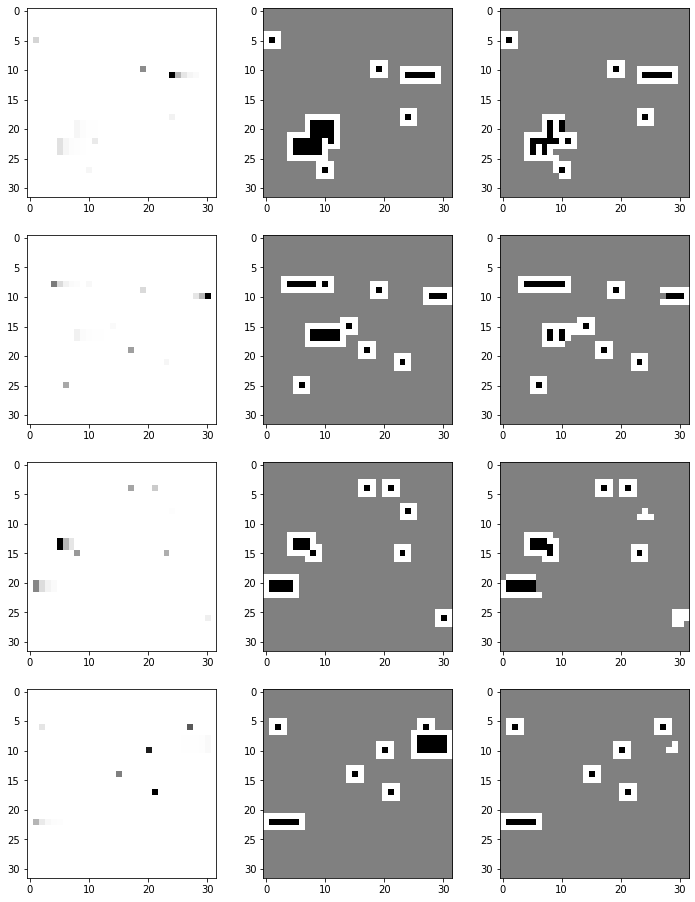

In [ ]:
num_example_to_display = 4

fig, axs = plt.subplots(nrows=num_example_to_display, ncols=3, figsize=(12,4*num_example_to_display))
  
for i in range(num_example_to_display):
  axs[i][0].imshow(val_img[i])
  axs[i][1].imshow(np.squeeze(val_mask[i],-1), cmap='gray');
  axs[i][2].imshow(np.squeeze(pred_mask[i],-1), cmap='gray')

### T2: Instance Detection

In [ ]:
import cv2

In [ ]:
val_mask = np.array(val_mask)

val_mask[np.where(val_mask == 2)] = 1
pred_mask[np.where(pred_mask == 2)] = 1

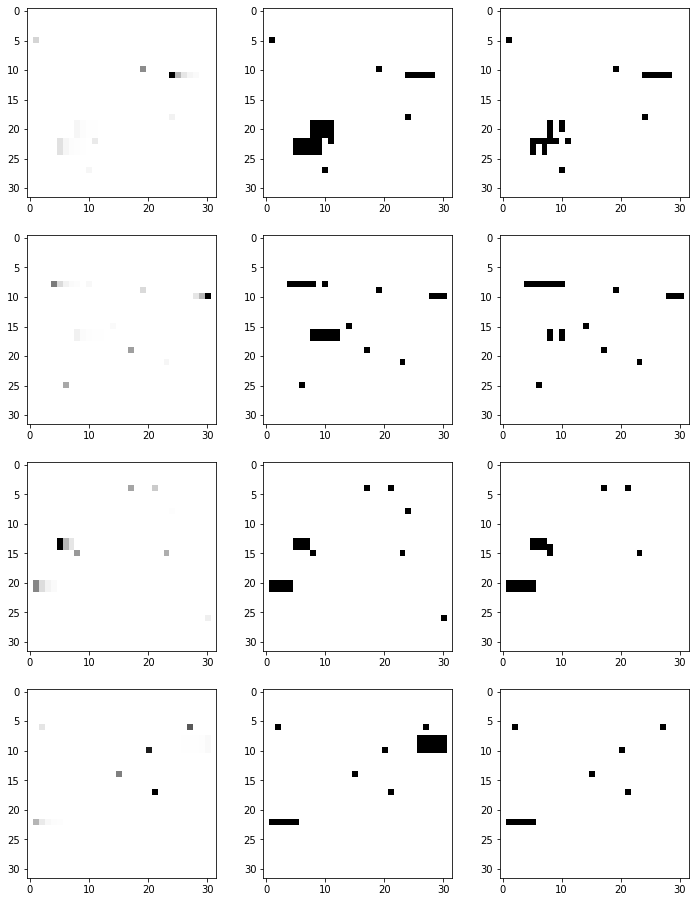

In [ ]:
num_example_to_display = 4

fig, axs = plt.subplots(nrows=num_example_to_display, ncols=3, figsize=(12,4*num_example_to_display))

for i in range(num_example_to_display):
  axs[i][0].imshow(val_img[i])
  axs[i][1].imshow(np.squeeze(val_mask[i],-1), cmap='gray')
  axs[i][2].imshow(np.squeeze(pred_mask[i],-1), cmap='gray')

In [ ]:
def ccl_generator(pred, mc_truth):
  test_image = np.squeeze(pred).astype("uint8")
  thresh = cv2.threshold(test_image, 0, 255,
    cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

  output_pred = cv2.connectedComponentsWithStats(
    thresh, 4, cv2.CV_32S)
  (numLabels_pred, labels_pred, stats_pred, centroids) = output_pred

  test_image = np.squeeze(mc_truth).astype("uint8")
  thresh = cv2.threshold(test_image, 0, 255,
    cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

  output_mc = cv2.connectedComponentsWithStats(
    thresh, 4, cv2.CV_32S)
  (numLabels_mc, labels_mc, stats_mc, centroids) = output_mc

  return labels_pred, labels_mc

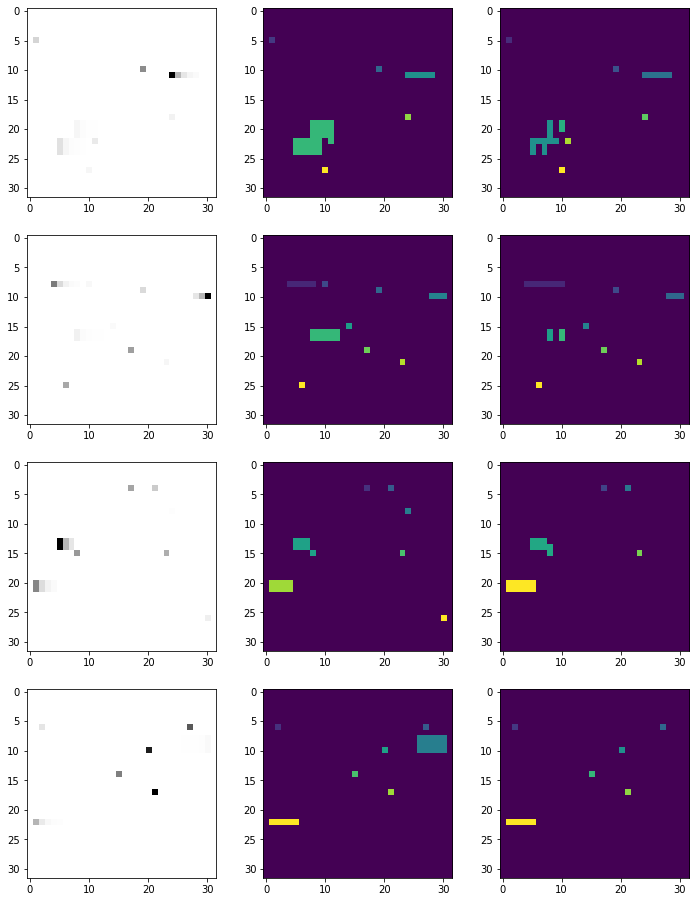

In [ ]:
num_example_to_display = 4
fig, axs = plt.subplots(nrows=num_example_to_display, ncols=3, figsize=(12,4*num_example_to_display))
  
for i in range(num_example_to_display):
  lpred, lmc = ccl_generator(pred_mask[i], val_mask[i])
  axs[i][0].imshow(val_img[i])
  axs[i][1].imshow(lmc)
  axs[i][2].imshow(lpred)

### Testing

#### Helper Code

In [ ]:
from collections import Counter

def eta_phi_res(ROI_mc, ROI_algo):
    eta_mc = max(ROI_mc[0]) - min(ROI_mc[0])
    phi_mc = max(ROI_mc[1]) - min(ROI_mc[1])

    eta_algo = max(ROI_algo[0]) - min(ROI_algo[0])
    phi_algo = max(ROI_algo[1]) - min(ROI_algo[1])

    return abs(eta_mc - eta_algo), abs(phi_mc - phi_algo)

In [ ]:
def mc_label_convert(segmented_image, mc_truth):
    all_labels = np.unique(mc_truth)
    hm = {}
    for curr_label in all_labels:
        selected_ROI = segmented_image[np.where(mc_truth == curr_label)]
        hm[curr_label] = np.unique(selected_ROI)
    
    bkg = []
    for lt in hm.values():
        bkg.extend(lt)

    bkg_label = Counter(bkg).most_common(1)[-1][0]

    #setting background label
    segmented_image[np.where(segmented_image == bkg_label)] = 0.0
    hm.pop(0.0)
    
    for label in list(hm.keys())[::-1]:
        marked_pixels = []
        for pxm in hm[label]:
            if pxm == bkg_label:
                continue
                
            marked_pixels.append(np.where(segmented_image==pxm))
            
        for mp in marked_pixels:
            segmented_image[mp] = label

    return segmented_image

In [ ]:
def test(predicted, mc_truth, energy_snap):
    thresh = 3
    y_pred = []
    energy_dist = []
    for label in np.unique(mc_truth):
        if label == 0.0:
            continue

        matched, rel_energy = False, -1
        ROI_mc = np.where(mc_truth==label)
        ROI_algo = np.where(predicted==label)

        E_mc = np.sum(energy_snap[ROI_mc])
        E_algo = np.sum(energy_snap[ROI_algo])

        if len(ROI_algo[0]) == 0:
            matched = (False, "False Negative")
            rel_energy = 1

        elif len(ROI_mc[0]) == 0 and len(ROI_algo[0]) !=0:
            matched = (False, "False Positive")
            rel_energy = 1

        else:
            eta_res, phi_res = eta_phi_res(ROI_mc, ROI_algo)

            if eta_res < thresh and phi_res < thresh:
                matched = True
                rel_energy = abs(E_algo - E_mc)/E_mc
            else:
                matched = (False, "Very Low Overlap")
                rel_energy = 1

        # collecting testing data
        y_pred.append(matched)
        if rel_energy >= 0: energy_dist.append(rel_energy)
    
    return y_pred, energy_dist

#### Main run

In [ ]:
val_img, val_mask, pred_mask = [], [], []
for _ in range(30):
  val_img_i, val_mask_i = next(iter(maintestloader))
  pred_mask_i = model.predict(val_img_i)
  pred_mask_i = np.argmax(pred_mask_i, axis=-1)
  pred_mask_i = np.expand_dims(pred_mask_i, axis=-1)

  val_img.extend(val_img_i)
  val_mask.extend(val_mask_i)
  pred_mask.extend(pred_mask_i)

1/1 [==============================] - 0s 32ms/step


In [ ]:
val_img = np.array(val_img)
val_mask = np.array(val_mask)
pred_mask = np.array(pred_mask)

In [ ]:
all_matched, all_rel_energy, sn = [], [], 0
for i in range(len(val_img)):
    CLUSTER_TAGS = [-1]
    energy_snap = np.squeeze(val_img[i])
    lpred, lmc = ccl_generator(pred_mask[i], val_mask[i])
    try:
        predicted = mc_label_convert(lpred, lmc)
        matched, rel_energy = test(predicted, lmc, energy_snap)

        # matched
        all_matched.extend(matched)
        all_rel_energy.extend(rel_energy)

        sn += 1
    except:
        print("Error in ", i)
        pass

<ipython-input-37-9a2aef8bba00>:29: RuntimeWarning: invalid value encountered in float_scalars
  rel_energy = abs(E_algo - E_mc)/E_mc


Text(0.5, 0, 'normalized energy difference')

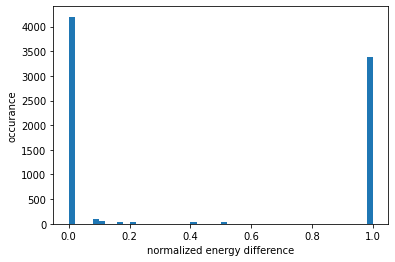

In [ ]:
sub_rel = [i for i in all_rel_energy if i<=1]
plt.hist(sub_rel, bins=50)  # density=False would make counts
plt.ylabel('occurance')
plt.xlabel('normalized energy difference')

In [ ]:
matches = len([x for x in all_matched if x==True])
print("Correct Matches: ", matches)
print("Incorrect Matched: ", len(all_matched) - matches)

Correct Matches:  4620
Incorrect Matched:  3390


In [ ]:
unmatched = [x[1] for x in all_matched if type(x)==tuple]

In [ ]:
threshold_mismatch = len([x for x in unmatched if x=='Very Low Overlap'])
print("Threshold Mismatch: ", threshold_mismatch)

fneg = len([x for x in unmatched if x=='False Negative'])
print("False Negative: ", fneg)

fposi = len([x for x in unmatched if x=='False Positive'])
print("False Positive: ", fposi)

Threshold Mismatch:  750
False Negative:  2640
False Positive:  0
